# Energy Consumption Data Preparation

This notebook focuses on loading, inspecting, and preparing the energy consumption data for further analysis and modeling. The steps include:
1. Loading the raw data.
2. Performing an initial inspection to identify missing values or inconsistencies.
3. Preparing the data by handling missing values, correcting data types, and creating new features.
4. Saving the cleaned and processed data for further use.


## Setup
Include all necessary imports and define paths for raw and processed data files.


In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Define file paths
raw_data_path = "../data/raw/hourly_energy_consumption_pjme.csv"
processed_data_path = "../data/processed/cleaned_energy_consumption.csv"

# Verify matplotlib installation (optional)
print(f"Matplotlib version: {plt.matplotlib.__version__}")


Matplotlib version: 3.10.0


## Loading the Data

In this section, we load the raw energy consumption dataset and verify its structure by displaying the first few rows.


In [2]:
# Load the dataset
energy_data = pd.read_csv(raw_data_path)

# Display the first few rows of the dataset
print(energy_data.head())

# Check data types and missing values
print(energy_data.info())


              Datetime  PJME_MW
0  2002-12-31 01:00:00  26498.0
1  2002-12-31 02:00:00  25147.0
2  2002-12-31 03:00:00  24574.0
3  2002-12-31 04:00:00  24393.0
4  2002-12-31 05:00:00  24860.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB
None


## Initial Inspection

Here, we inspect the dataset for:
1. Missing values.
2. Data types and inconsistencies.
3. Basic statistics to understand variable distributions.


In [3]:
# Check for missing values
print("Missing values per column:")
print(energy_data.isnull().sum())

# Summary statistics for numerical columns
print("Summary statistics:")
print(energy_data.describe())


Missing values per column:
Datetime    0
PJME_MW     0
dtype: int64
Summary statistics:
             PJME_MW
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000


## Data Preparation

This section includes:
1. Handling missing values (if applicable).
2. Converting data types (e.g., `Datetime` column).
3. Creating new features for analysis (e.g., hour of day, day of week).
4. Saving the processed dataset for future use.

In [4]:
# Convert 'Datetime' column to datetime type
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime'])

# Set 'Datetime' as index for time series analysis
energy_data.set_index('Datetime', inplace=True)

# Create new features: hour of day and day of week
energy_data['hour'] = energy_data.index.hour
energy_data['day_of_week'] = energy_data.index.dayofweek

# Save processed data to 'processed' folder
energy_data.to_csv(processed_data_path)


## Initial Visualization

We will visualize:
1. Energy consumption over time.
2. The distribution of energy consumption values.


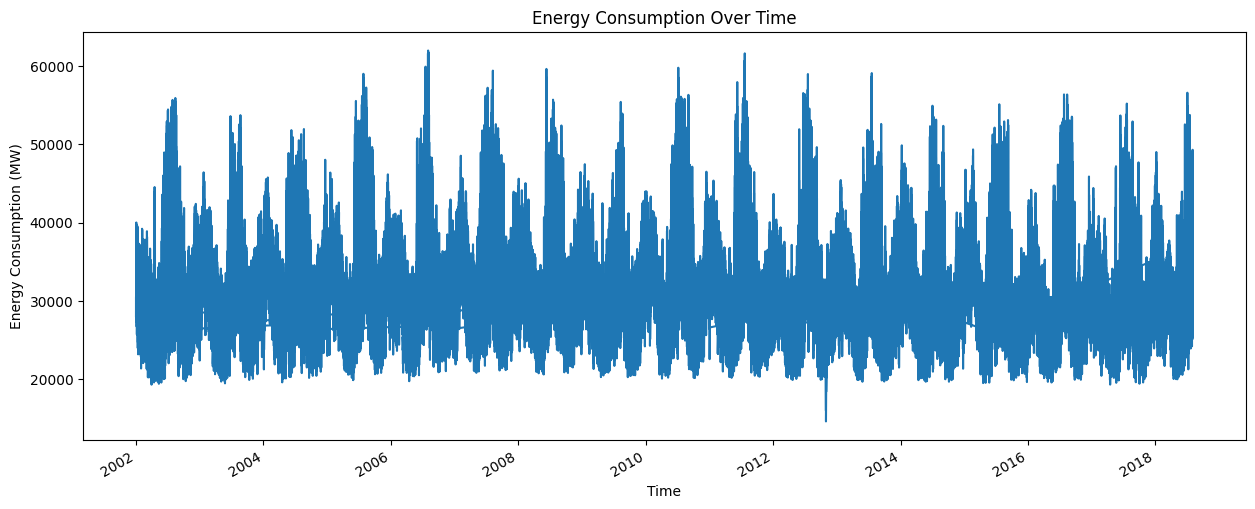

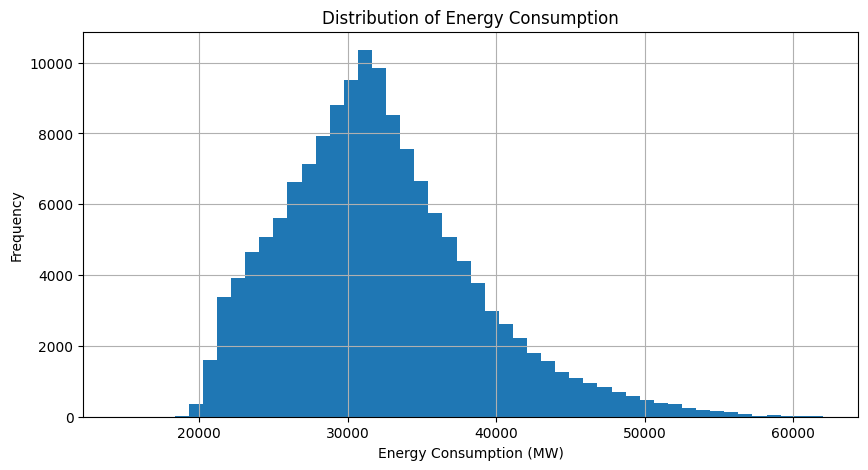

In [5]:
# Plot time series of energy consumption
energy_data['PJME_MW'].plot(figsize=(15, 6), title='Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.show()

# Plot histogram of energy consumption values
energy_data['PJME_MW'].hist(bins=50, figsize=(10, 5))
plt.title('Distribution of Energy Consumption')
plt.xlabel('Energy Consumption (MW)')
plt.ylabel('Frequency')
plt.show()


## Conclusion and Next Steps

### Summary:
1. Loaded and inspected the raw dataset `hourly_energy_consumption_pjme.csv`.
2. Checked for missing values (none found).
3. Converted `Datetime` column to datetime format and set it as index.
4. Created new features (`hour`, `day_of_week`) for further analysis.
5. Saved cleaned data to `../data/processed/cleaned_energy_consumption.csv`.

### Next Steps:
- Perform detailed exploratory data analysis (EDA) to identify patterns in energy consumption.
- Integrate additional datasets (e.g., weather data) for feature enrichment.
- Prepare final datasets for modeling.
